In [70]:

from nuscenes.nuscenes import NuScenesExplorer, NuScenes

import json
import math
import os
import os.path as osp
import sys
import time
from datetime import datetime
from typing import Tuple, List, Iterable

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from tqdm import tqdm

from nuscenes.lidarseg.lidarseg_utils import colormap_to_colors, \
    get_labels_in_coloring, create_lidarseg_legend, paint_points_label
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.map_mask import MapMask
from nuscenes.utils.color_map import get_colormap

color_mapping = [
    np.array([140, 140, 136]) / 255.0,
    np.array([4, 157, 217]) / 255.0,
    np.array([191, 4, 54]) / 255.0,
    np.array([0, 0, 0]) / 255.0,
    np.array([224, 133, 250]) / 255.0, 
    np.array([32, 64, 40]) / 255.0,
    np.array([77, 115, 67]) / 255.0
]

print('Using color mapping', color_mapping)


class NuScenesMars(NuScenes):
    def __init__(self, 
                 version: str = 'v1.0-trainval',
                 dataroot: str = '/opt/zhh/nuscenes/',
                 verbose: bool = True,
                 map_resolution: float = 0.1):
        super().__init__(version, dataroot, verbose, map_resolution)
        
    
    def get_box(self, sample_annotation_token: str) -> Box:
        """
        Instantiates a Box class from a sample annotation record.
        :param sample_annotation_token: Unique sample_annotation identifier.
        """
        record = self.get('sample_annotation', sample_annotation_token)
        velocity = self.box_velocity(sample_annotation_token)
        return Box(record['translation'], record['size'], Quaternion(record['rotation']),
                   name=record['category_name'], token=record['token'], velocity=velocity)

    def get_sample_data_given_boxes(self, sample_data_token: str,
                                    boxes: List[Box],
                                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                                    selected_anntokens: List[str] = None,
                                    use_flat_vehicle_coordinates: bool = False) -> \
            Tuple[str, List[Box], np.array]:
        """
        Returns the data path as well as all annotations related to that sample_data.
        Note that the boxes are transformed into the current sensor's coordinate frame.
        :param sample_data_token: Sample_data token.
        :param boxes: List of Boxes in global frame. 
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param selected_anntokens: If provided only return the selected annotation.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                             aligned to z-plane in the world.
        :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
        """

        # Retrieve sensor & pose records
        sd_record = self.get('sample_data', sample_data_token)
        cs_record = self.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
        sensor_record = self.get('sensor', cs_record['sensor_token'])
        pose_record = self.get('ego_pose', sd_record['ego_pose_token'])

        data_path = self.get_sample_data_path(sample_data_token)

        if sensor_record['modality'] == 'camera':
            cam_intrinsic = np.array(cs_record['camera_intrinsic'])
            imsize = (sd_record['width'], sd_record['height'])
        else:
            cam_intrinsic = None
            imsize = None

        # map boxes from global frame to sensor coordinate system.

        # Make list of Box objects including coord system transforms.
        box_list = []
        for box in boxes:
            if use_flat_vehicle_coordinates:
                # Move box to ego vehicle coord system parallel to world z plane.
                yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
            else:
                # Move box to ego vehicle coord system.
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(pose_record['rotation']).inverse)

                #  Move box to sensor coord system.
                box.translate(-np.array(cs_record['translation']))
                box.rotate(Quaternion(cs_record['rotation']).inverse)

            if sensor_record['modality'] == 'camera' and not \
                    box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
                continue

            box_list.append(box)

        return data_path, box_list, cam_intrinsic


class NuScenesExplorerMars(NuScenesExplorer):

    def __init__(self, nusc: NuScenesMars):
        super().__init__(nusc)
        self.nusc = nusc
    
    def render_sample_data(self,
                           sample_data_token: str,
                           with_anns: bool = True,
                           box_vis_level: BoxVisibility = BoxVisibility.ANY,
                           axes_limit: float = 40,
                           ax: Axes = None,
                           nsweeps: int = 1,
                           out_path: str = None,
                           underlay_map: bool = True,
                           use_flat_vehicle_coordinates: bool = True,
                           show_lidarseg: bool = False,
                           show_lidarseg_legend: bool = False,
                           filter_lidarseg_labels: List = None,
                           lidarseg_preds_bin_path: str = None,
                           verbose: bool = True,
                           show_panoptic: bool = False,
                           show_radar_raw_velo: bool = False) -> None:
        """
        Render sample data onto axis.
        :param sample_data_token: Sample_data token.
        :param with_anns: Whether to draw box annotations.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param axes_limit: Axes limit for lidar and radar (measured in meters).
        :param ax: Axes onto which to render.
        :param nsweeps: Number of sweeps for lidar and radar.
        :param out_path: Optional path to save the rendered figure to disk.
        :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
            aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
            can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
            setting is more correct and rotates the plot by ~90 degrees.
        :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
        :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
            or the list is empty, all classes will be displayed.
        :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                        predictions for the sample.
        :param verbose: Whether to display the image after it is rendered.
        :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
            If show_lidarseg is True, show_panoptic will be set to False.
        """
        # Get sensor modality.
        sd_record = self.nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            sample_rec = self.nusc.get('sample', sd_record['sample_token'])
            chan = sd_record['channel']
            ref_chan = 'LIDAR_TOP'
            ref_sd_token = sample_rec['data'][ref_chan]
            ref_sd_record = self.nusc.get('sample_data', ref_sd_token)

            if sensor_modality == 'lidar':
                # Get aggregated lidar point cloud in lidar frame.
                pc, times = LidarPointCloud.from_file_multisweep(self.nusc, sample_rec, chan, ref_chan,
                                                                    nsweeps=nsweeps)
                velocities = None
            else:
                # Get aggregated radar point cloud in reference frame.
                # The point cloud is transformed to the reference frame for visualization purposes.
                pc, times = RadarPointCloud.from_file_multisweep(self.nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)

                # Transform radar velocities (x is front, y is left), as these are not transformed when loading the
                # point cloud.
                radar_cs_record = self.nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
                ref_cs_record = self.nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                velocities = pc.points[8:10, :]  # Compensated velocity
                velocities = np.vstack((velocities, np.zeros(pc.points.shape[1])))
                velocities = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities)
                velocities = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities)
                velocities[2, :] = np.zeros(pc.points.shape[1])
                
                if show_radar_raw_velo:
                    # code for radar velocity without compensated starts below
                    velocities_ = pc.points[6:8, :]  # Not Compensated velocity
                    velocities_ = np.vstack((velocities_, np.zeros(pc.points.shape[1])))
                    velocities_ = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities_)
                    velocities_ = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities_)
                    velocities_[2, :] = np.zeros(pc.points.shape[1])
                    # code for radar velocity without compensated end here

            # By default we render the sample_data top down in the sensor frame.
            # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
            # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
            if use_flat_vehicle_coordinates:
                # Retrieve transformation matrices for reference point cloud.
                cs_record = self.nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                pose_record = self.nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
                ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                              rotation=Quaternion(cs_record["rotation"]))

                # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
                ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                rotation_vehicle_flat_from_vehicle = np.dot(
                    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
                vehicle_flat_from_vehicle = np.eye(4)
                vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
                viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
            else:
                viewpoint = np.eye(4)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            # Render map if requested.
            if underlay_map:
                assert use_flat_vehicle_coordinates, 'Error: underlay_map requires use_flat_vehicle_coordinates, as ' \
                                                     'otherwise the location does not correspond to the map!'
                self.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)

            # Show point cloud.
            points = view_points(pc.points[:3, :], viewpoint, normalize=False)
            dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
                
            point_scale = 0.2 if sensor_modality == 'lidar' else 3.0
            scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)

            # Show velocities.
            if sensor_modality == 'radar':
                points_vel = view_points(pc.points[:3, :] + velocities, viewpoint, normalize=False)
                deltas_vel = points_vel - points
                deltas_vel = 6 * deltas_vel  # Arbitrary scaling
                max_delta = 20
                deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
                
                if show_radar_raw_velo:
                    # code for radar velocity without compensated starts below
                    points_vel_ = view_points(pc.points[:3, :] + velocities_, viewpoint, normalize=False)
                    deltas_vel_ = points_vel_ - points
                    deltas_vel_ = 6 * deltas_vel_  # Arbitrary scaling
                    deltas_vel_ = np.clip(deltas_vel_, -max_delta, max_delta)  # Arbitrary clipping
                    # code for radar velocity without compensated end here
                
                colors_rgba = scatter.to_rgba(colors)
                for i in range(points.shape[1]):
                    ax.arrow(points[0, i], points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])
                    
                    if show_radar_raw_velo:
                        # code for radar velocity without compensated starts below
                        ax.arrow(points[0, i], points[1, i], deltas_vel_[0, i], deltas_vel_[1, i], color='pink')
                        # code for radar velocity without compensated end here

            # Show ego vehicle.
            ax.plot(0, 0, 'x', color='red')

            # Get boxes in lidar frame.
            _, boxes, _ = self.nusc.get_sample_data(ref_sd_token, box_vis_level=box_vis_level,
                                                    use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    
                    c = np.array(self.get_color(box.name)) / 255.0
                    box.render(ax, view=np.eye(4), colors=(c, c, c))
                    ax.arrow(
                        box.center[0], box.center[1], box.velocity[0], box.velocity[1],
                        color='cyan', width=0.25, )


            # Limit visible range.
            ax.set_xlim(-axes_limit, axes_limit)
            ax.set_ylim(-axes_limit, axes_limit)
        elif sensor_modality == 'camera':
            # Load boxes and image.
            data_path, boxes, camera_intrinsic = self.nusc.get_sample_data(sample_data_token,
                                                                           box_vis_level=box_vis_level)
            data = Image.open(data_path)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 16))

            # Show image.
            ax.imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(self.get_color(box.name)) / 255.0
                    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))
                    center = box.center[:, np.newaxis]
                    velo = box.velocity[:, np.newaxis]
                    center_cam = view_points(center, camera_intrinsic, normalize=True)[:, 0]
                    center_add_velo_cam = view_points(center + velo, camera_intrinsic, normalize=True)[:, 0]
                    
                    delta = center_add_velo_cam - center_cam
                    ax.arrow(
                        center_cam[0], center_cam[1], delta[0], delta[1],
                        color='cyan', width=3.0, )
                    

            # Limit visible range.
            ax.set_xlim(0, data.size[0])
            ax.set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax.axis('off')
        ax.set_title('{} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax.set_aspect('equal')

        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)

        if verbose:
            plt.show()
        
    def render_sample_pred(self,
                           sample_data_token: str,
                           boxes: List[Box],
                           with_anns: bool = True,
                           box_vis_level: BoxVisibility = BoxVisibility.ANY,
                           axes_limit: float = 40,
                           ax: Axes = None,
                           nsweeps: int = 1,
                           out_path: str = None,
                           underlay_map: bool = True,
                           use_flat_vehicle_coordinates: bool = True,
                           show_lidarseg: bool = False,
                           show_lidarseg_legend: bool = False,
                           filter_lidarseg_labels: List = None,
                           lidarseg_preds_bin_path: str = None,
                           verbose: bool = True,
                           show_panoptic: bool = False,
                           show_radar_raw_velo: bool = False) -> None:
        """
        Render sample data onto axis.
        :param sample_data_token: Sample_data token.
        :param with_anns: Whether to draw box annotations.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param axes_limit: Axes limit for lidar and radar (measured in meters).
        :param ax: Axes onto which to render.
        :param nsweeps: Number of sweeps for lidar and radar.
        :param out_path: Optional path to save the rendered figure to disk.
        :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
            aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
            can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
            setting is more correct and rotates the plot by ~90 degrees.
        :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
        :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
            or the list is empty, all classes will be displayed.
        :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                        predictions for the sample.
        :param verbose: Whether to display the image after it is rendered.
        :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
            If show_lidarseg is True, show_panoptic will be set to False.
        """
        # Get sensor modality.
        sd_record = self.nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            sample_rec = self.nusc.get('sample', sd_record['sample_token'])
            chan = sd_record['channel']
            ref_chan = 'LIDAR_TOP'
            ref_sd_token = sample_rec['data'][ref_chan]
            ref_sd_record = self.nusc.get('sample_data', ref_sd_token)

            if sensor_modality == 'lidar':
                # Get aggregated lidar point cloud in lidar frame.
                pc, times = LidarPointCloud.from_file_multisweep(self.nusc, sample_rec, chan, ref_chan,
                                                                    nsweeps=nsweeps)
                velocities = None
            else:
                # Get aggregated radar point cloud in reference frame.
                # The point cloud is transformed to the reference frame for visualization purposes.
                pc, times = RadarPointCloud.from_file_multisweep(self.nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)

                # Transform radar velocities (x is front, y is left), as these are not transformed when loading the
                # point cloud.
                radar_cs_record = self.nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
                ref_cs_record = self.nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                velocities = pc.points[8:10, :]  # Compensated velocity
                velocities = np.vstack((velocities, np.zeros(pc.points.shape[1])))
                velocities = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities)
                velocities = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities)
                velocities[2, :] = np.zeros(pc.points.shape[1])
                
                if show_radar_raw_velo:
                    # code for radar velocity without compensated starts below
                    velocities_ = pc.points[6:8, :]  # Not Compensated velocity
                    velocities_ = np.vstack((velocities_, np.zeros(pc.points.shape[1])))
                    velocities_ = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities_)
                    velocities_ = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities_)
                    velocities_[2, :] = np.zeros(pc.points.shape[1])
                    # code for radar velocity without compensated end here

            # By default we render the sample_data top down in the sensor frame.
            # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
            # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
            if use_flat_vehicle_coordinates:
                # Retrieve transformation matrices for reference point cloud.
                cs_record = self.nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                pose_record = self.nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
                ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                              rotation=Quaternion(cs_record["rotation"]))

                # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
                ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                rotation_vehicle_flat_from_vehicle = np.dot(
                    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
                vehicle_flat_from_vehicle = np.eye(4)
                vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
                viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
            else:
                viewpoint = np.eye(4)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            # Render map if requested.
            if underlay_map:
                assert use_flat_vehicle_coordinates, 'Error: underlay_map requires use_flat_vehicle_coordinates, as ' \
                                                     'otherwise the location does not correspond to the map!'
                self.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)

            # Show point cloud.
            points = view_points(pc.points[:3, :], viewpoint, normalize=False)
            dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
                
            point_scale = 0.2 if sensor_modality == 'lidar' else 3.0
            scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)

            # Show velocities.
            if sensor_modality == 'radar':
                points_vel = view_points(pc.points[:3, :] + velocities, viewpoint, normalize=False)
                deltas_vel = points_vel - points
                deltas_vel = 6 * deltas_vel  # Arbitrary scaling
                max_delta = 20
                deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
                
                if show_radar_raw_velo:
                    # code for radar velocity without compensated starts below
                    points_vel_ = view_points(pc.points[:3, :] + velocities_, viewpoint, normalize=False)
                    deltas_vel_ = points_vel_ - points
                    deltas_vel_ = 6 * deltas_vel_  # Arbitrary scaling
                    deltas_vel_ = np.clip(deltas_vel_, -max_delta, max_delta)  # Arbitrary clipping
                    # code for radar velocity without compensated end here
                
                colors_rgba = scatter.to_rgba(colors)
                for i in range(points.shape[1]):
                    ax.arrow(points[0, i], points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])
                    
                    if show_radar_raw_velo:
                        # code for radar velocity without compensated starts below
                        ax.arrow(points[0, i], points[1, i], deltas_vel_[0, i], deltas_vel_[1, i], color='pink')
                        # code for radar velocity without compensated end here

            # Show ego vehicle.
            ax.plot(0, 0, 'x', color='red')

            # Get boxes in lidar frame.
            _, boxes, _ = self.nusc.get_sample_data_given_boxes(
                ref_sd_token, boxes, box_vis_level=box_vis_level,
                use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)
            # _, gt_boxes, _ = self.nusc.get_sample_data(ref_sd_token, box_vis_level=box_vis_level,
            #                                         use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)
            # # Show gtboxes.
            # if with_anns:
            #     for box in gt_boxes:
                    
            #         c = np.array(self.get_color(box.name)) / 255.0
            #         box.render(ax, view=np.eye(4), colors=(c,c,c))
            #         ax.arrow(
            #             box.center[0], box.center[1], box.velocity[0], box.velocity[1],
            #             color=(1,0,0), width=0.25, )

            # Show boxes.
            if with_anns:
                for i, box in enumerate(boxes):
                    

                    c = np.array(self.get_color(box.name)) / 255.0
                    if hasattr(box, 'track_ind'): # this is true
                        tr_id = box.track_ind
                        c = color_mapping[tr_id  % len(color_mapping)]
                    # print(c_box)
                    # print("original color", np.array(self.get_color(box.name)) / 255.0)
                    box.render(ax, view=np.eye(4), colors=((1,0,0),(1,0,0),(1,0,0)))
                    # print(c_box, np.array(self.get_color(box.name)) / 255.0)
                    ax.arrow(
                        box.center[0], box.center[1], box.velocity[0], box.velocity[1],
                        color=c, width=0.25, )
                        # color='cyan', width=0.25, )


            # Limit visible range.
            ax.set_xlim(-axes_limit, axes_limit)
            ax.set_ylim(-axes_limit, axes_limit)
        elif sensor_modality == 'camera':
            # Load boxes and image.
            data_path, boxes, camera_intrinsic = self.nusc.get_sample_data_given_boxes(
                sample_data_token, boxes, box_vis_level=box_vis_level)
            data = Image.open(data_path)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 16))

            # Show image.
            ax.imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(self.get_color(box.name)) / 255.0
                    if hasattr(box, 'track_ind'): # this is true
                        tr_id = box.track_ind
                        c = color_mapping[tr_id  % len(color_mapping)]
                    #  if hasattr(box, 'track_ind'): # this is true
                    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))
                    center = box.center[:, np.newaxis]
                    velo = box.velocity[:, np.newaxis]
                    center_cam = view_points(center, camera_intrinsic, normalize=True)[:, 0]
                    center_add_velo_cam = view_points(center + velo, camera_intrinsic, normalize=True)[:, 0]
                    
                    delta = center_add_velo_cam - center_cam
                    ax.arrow(
                        center_cam[0], center_cam[1], delta[0], delta[1],
                        color=c, width=3.0, )
                        # color='cyan', width=3.0, )
                    

            # Limit visible range.
            ax.set_xlim(0, data.size[0])
            ax.set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax.axis('off')
        ax.set_title('{} {labels_type} - Pred'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax.set_aspect('equal')

        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)

        if verbose:
            plt.show()


def load_results_json(results_path: str = None):
    NameMapping = {
        'movable_object.barrier': 'barrier',
        'vehicle.bicycle': 'bicycle',
        'vehicle.bus.bendy': 'bus',
        'vehicle.bus.rigid': 'bus',
        'vehicle.car': 'car',
        'vehicle.construction': 'construction_vehicle',
        'vehicle.motorcycle': 'motorcycle',
        'human.pedestrian.adult': 'pedestrian',
        'human.pedestrian.child': 'pedestrian',
        'human.pedestrian.construction_worker': 'pedestrian',
        'human.pedestrian.police_officer': 'pedestrian',
        'movable_object.trafficcone': 'traffic_cone',
        'vehicle.trailer': 'trailer',
        'vehicle.truck': 'truck'}
    
    inverse_mapping = {}
    for key, value in NameMapping.items():
        inverse_mapping[value] = key
    with open(results_path) as f:
        data = json.load(f)

    results_dict = data['results']
    new_results_dict = {}
    
    for key, item in results_dict.items():
        new_item = []
        for _box_dict in item:
            if 'detection_name' in _box_dict:
                # load detection box
                score=_box_dict['detection_score']
                if score < 0.20:
                    continue
                new_box = Box(
                    center=_box_dict['translation'],
                    size=_box_dict['size'],
                    orientation=Quaternion(_box_dict['rotation']),
                    score=_box_dict['detection_score'],
                    velocity=_box_dict['velocity'] + [0],
                    name=inverse_mapping[_box_dict['detection_name']],
                    token=_box_dict['sample_token'])
            else:
                # then it is track box
                center_ = _box_dict['translation']
                new_box = Box(
                    center=center_,
                    size=_box_dict['size'],
                    orientation=Quaternion(_box_dict['rotation']),
                    label=int(_box_dict['tracking_id']),
                    score=_box_dict['tracking_score'],
                    velocity=_box_dict['velocity'] + [0],
                    name=inverse_mapping[_box_dict['tracking_name']],
                    token=_box_dict['sample_token'])
                new_box.track_ind = int(_box_dict['tracking_id'])
            new_item.append(new_box)
        
        new_results_dict[key] = new_item

    print('loading total of {} boxes'.format(len(new_results_dict)))
            

    return new_results_dict


results_path_0="/opt/zhh/results_json/results_nusc_purevision.json"#纯视觉
results_path_1="/opt/zhh/results_json/results_nusc_orign_tribule.json"#原始加三
results_path_2="/opt/zhh/results_json/results_nusc_rain.json"#雨天测试
results_path_3="/opt/zhh/results_json/results_nusc_night.json"#夜晚测试

results_dict_0 = load_results_json(results_path_0)
results_dict_1 = load_results_json(results_path_1)
results_dict_2 = load_results_json(results_path_2)
results_dict_3 = load_results_json(results_path_3)
    


Using color mapping [array([0.54901961, 0.54901961, 0.53333333]), array([0.01568627, 0.61568627, 0.85098039]), array([0.74901961, 0.01568627, 0.21176471]), array([0., 0., 0.]), array([0.87843137, 0.52156863, 0.98039216]), array([0.1254902 , 0.25098039, 0.15686275]), array([0.30196078, 0.45098039, 0.2627451 ])]
loading total of 6019 boxes
loading total of 6019 boxes
loading total of 1088 boxes
loading total of 602 boxes


In [79]:

nusc = NuScenesMars(version='v1.0-trainval', dataroot='/opt/zhh/nuscenes/', verbose=False)
nusc_exp = NuScenesExplorerMars(nusc)
samples = nusc.sample

a = NuScenes(version='v1.0-trainval', dataroot='/opt/zhh/nuscenes/', verbose=False)


11a46849ff264ac3b75ba0709c4a0a35
真值


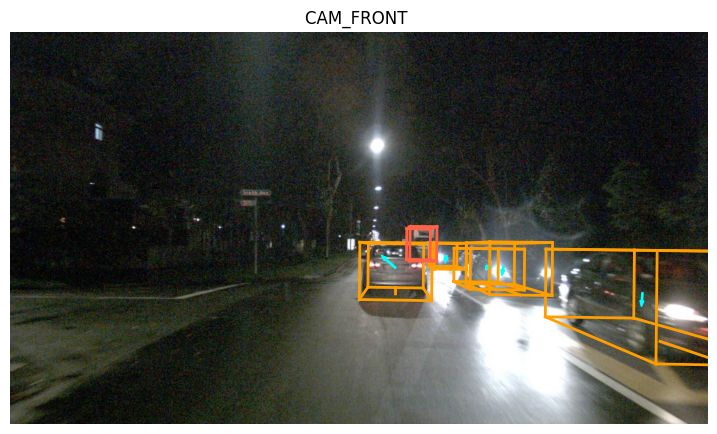

纯视觉


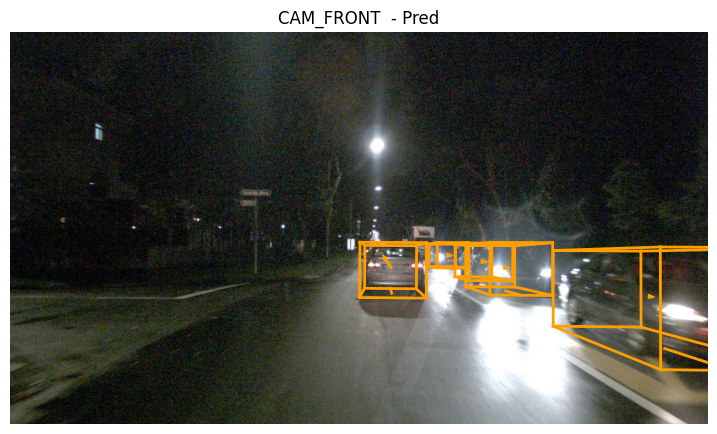

原始三枪


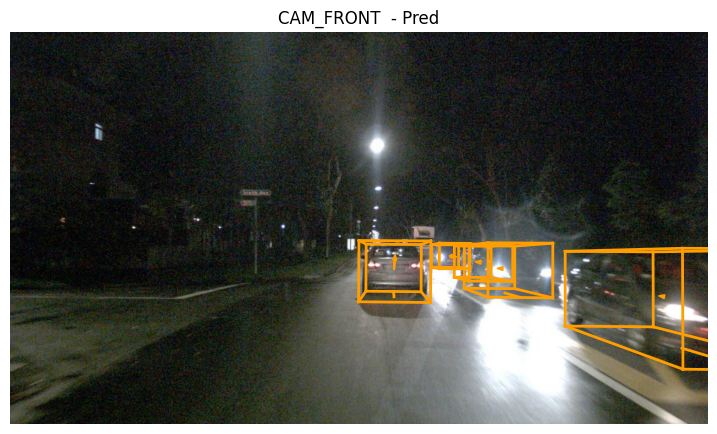

夜晚


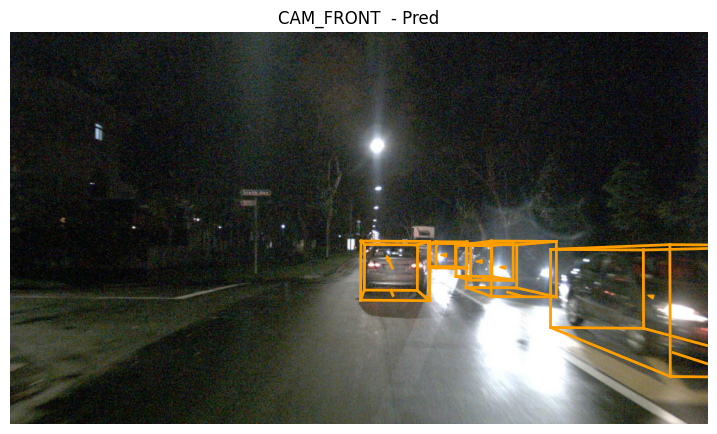

真值


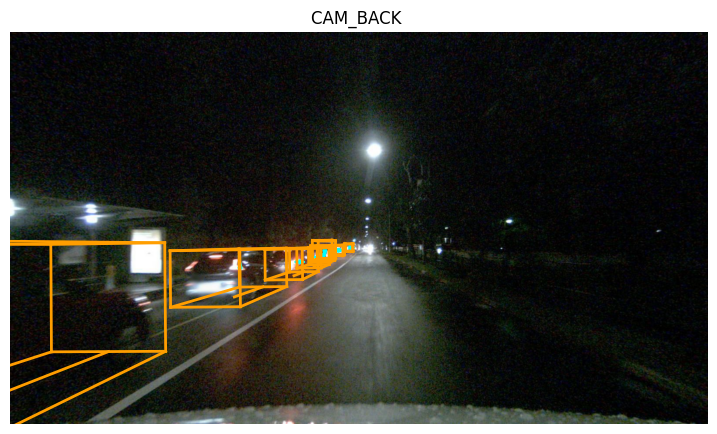

纯视觉


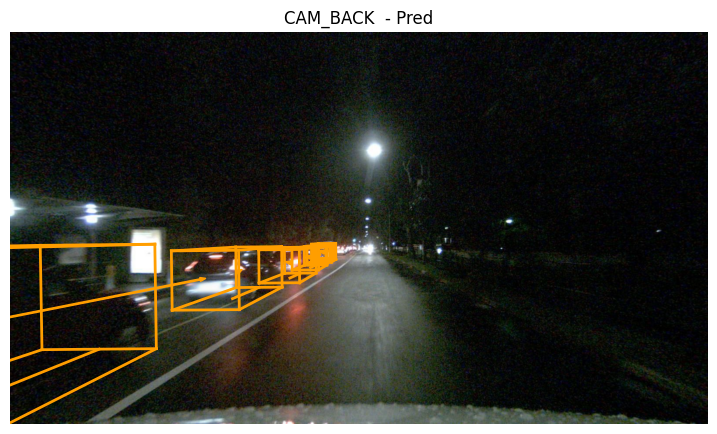

原始三枪


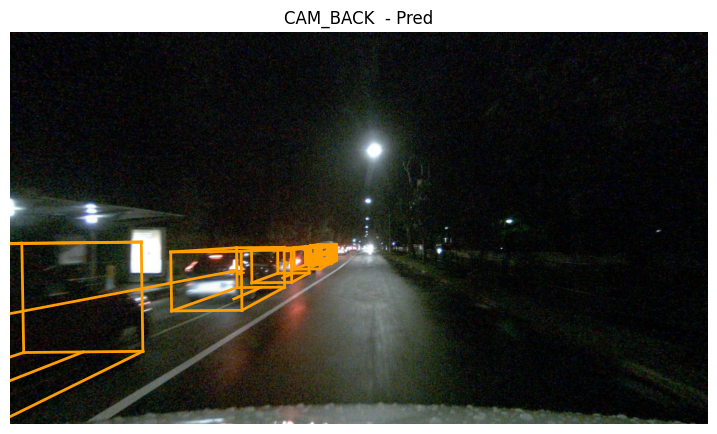

夜晚


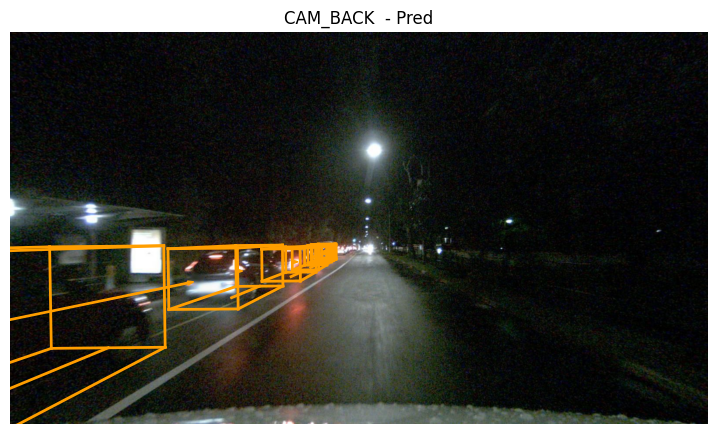

In [84]:
USED_SENSOR = ['CAM_FRONT',
  #               'CAM_FRONT_RIGHT', 
  # 'CAM_BACK_RIGHT', 
  'CAM_BACK', 
  # 'CAM_BACK_LEFT',
  # 'CAM_FRONT_LEFT'
  ]
selected_keys = list(results_dict_3.keys())[450]
# a.render_sample(selected_keys)
print(selected_keys)
selected_sample = nusc.get('sample', selected_keys)
import copy
for x in USED_SENSOR:
    selected_cam_token = selected_sample['data'][x]
    print("真值")
    nusc_exp.render_sample_data(selected_cam_token)
    print("纯视觉")
    c=copy.deepcopy(results_dict_0[selected_keys])
    nusc_exp.render_sample_pred(selected_cam_token,c)
    print("原始三枪")
    c_1=copy.deepcopy(results_dict_1[selected_keys])
    nusc_exp.render_sample_pred(selected_cam_token,c_1)
    print("夜晚")
    c_3=copy.deepcopy(results_dict_3[selected_keys])
    nusc_exp.render_sample_pred(selected_cam_token,c_3)
